# Install Python Packages

In [ ]:
!pip3 install pyyaml==5.1 pycocotools>=2.0.1 ipython
!pip3 install torch torchvision tensorflow 
!python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip3 install Pillow
!pip3 install pandas
!pip3 install scikit-learn funcy

# Check if tensorboard is installed, otherwise install it
!if [[ $(pip3 list | grep -c tensorboard) -eq 0 ]]; then pip3 install tensorboard; else echo "tensorboard already installed"; fi


In [ ]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

# Import Python Packages

In [ ]:
# Imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import pandas as pd
import os, json, shutil, cv2, random, datetime, torch, torchvision
import PIL
from PIL import Image
from IPython.display import Image as IImage
from IPython.display import display, HTML
from IPython.display import IFrame
import json, funcy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [ ]:
print(PIL.PILLOW_VERSION)

# Register Datasets

## synthetic aircraft dataset

In [ ]:
# Register train and test datasets
# coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/role_real_test_coco.json"
coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/instances_test_aircraft.json" # change into your dir
images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/test/images/" # change into your dir
register_coco_instances("dj_instance_test7", {}, coco_dir, images_dir)
# register_coco_instances("satrgb_test", {}, satrgbdir + datadir + 'test.json', satrgbdir + datadir + 'test/')

# Generate metadata
satrgb_metadata = MetadataCatalog.get("dj_instance_test7")
print(satrgb_metadata)

# Get train and test dataset catalogs
# train_dicts = DatasetCatalog.get("satrgb_train")
test_dicts = DatasetCatalog.get("dj_instance_test7")

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/test/images/', json_file='/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/instances_test_aircraft.json', name='dj_instance_test7')
[11/18 08:30:27 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/instances_test_aircraft.json


## real aircraft num_class = 1

In [ ]:
# Register train and test datasets
# coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/role_real_test_coco.json"
coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/aircraft_real_test_coco.json"
images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/test/RarePlanes_test_PS-RGB_tiled.tar.gz (Unzipped Files)/PS-RGB_tiled/"
register_coco_instances("dj_instance_test3", {}, coco_dir, images_dir)
# register_coco_instances("satrgb_test", {}, satrgbdir + datadir + 'test.json', satrgbdir + datadir + 'test/')

# Generate metadata
satrgb_metadata = MetadataCatalog.get("dj_instance_test3")
print(satrgb_metadata)


# Get train and test dataset catalogs
# train_dicts = DatasetCatalog.get("satrgb_train")
test_dicts = DatasetCatalog.get("dj_instance_test3")

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/test/RarePlanes_test_PS-RGB_tiled.tar.gz (Unzipped Files)/PS-RGB_tiled/', json_file='/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/aircraft_real_test_coco.json', name='dj_instance_test3')
[11/18 07:29:14 d2.data.datasets.coco]: Loaded 2710 images in COCO format from /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/aircraft_real_test_coco.json


## real role num_class = 7

this data is useless!

In [ ]:
# # Register train and test datasets
# coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/role_real_test_coco.json"
# images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/test/RarePlanes_test_PS-RGB_tiled.tar.gz (Unzipped Files)/PS-RGB_tiled/"
# register_coco_instances("dj_instance_test4", {}, coco_dir, images_dir)
# # register_coco_instances("satrgb_test", {}, satrgbdir + datadir + 'test.json', satrgbdir + datadir + 'test/')

# # Generate metadata
# satrgb_metadata = MetadataCatalog.get("dj_instance_test4")
# print(satrgb_metadata)


# # Get train and test dataset catalogs
# # train_dicts = DatasetCatalog.get("satrgb_train")
# test_dicts = DatasetCatalog.get("dj_instance_test4")

## real role num_class = 3

In this section, we will separate the civil role planes from all role-related images. We will do the followings:
1. load role data
2. filter out only civil planes
3. create civil role coco json file
4. create a new image dir which contains only civil role images.
5. In the end, we will use 3. and 4. to register civil role planes. 

In [ ]:
# 1. load role data
real_test_role_coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/role_real_test_coco.json" # change to your dir
real_imgs_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/test/RarePlanes_test_PS-RGB_tiled.tar.gz (Unzipped Files)/PS-RGB_tiled" # change to your dir
real_json_dir = real_test_role_coco_dir
with open(test_json_dir) as json_file:
    real_coco = json.load(json_file)
    
print(real_coco.keys())
print("Num images:{}".format(len(real_coco['images'])))
print("Num classes:{}".format(len(real_coco['categories'])))
print("Num bbox/instances:{}".format(len(real_coco['annotations'])))

dict_keys(['categories', 'images', 'annotations', 'licenses', 'info'])
Num images:5000
Num classes:3
Num bbox/instances:62841


In [ ]:
# merge images with annotations to get image dir
img_list_real = pd.DataFrame(real_coco['images'])
img_list_real.head()

annotations_real = pd.DataFrame(real_coco['annotations'])
annotations_real.head()

ann_real = annotations_real.merge(img_list_real, how='left', left_on="image_id", right_on="id")
ann_real.shape

(6812, 11)

create new directory with only images.

In [ ]:
# 2. filter out only civil planes
print("keep only the civil category planes, left with {} instances".format(ann_real[ann_real["category_id"] <=2].shape[0]))
civil_images_list = list(ann_real[ann_real["category_id"] <=2].file_name.unique())
print("keeping only {} images".format(len(civil_images_list)))

dict_keys(['annotations', 'categories', 'images'])
Num images:2710
Num classes:7
Num bbox/instances:6812
keep only the civil category planes, left with 6457 instances
keeping only 2601 images


In [ ]:
# 3. create civil role coco json file

role_real_test_coco_path = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/role_real_test_coco.json" # change to your dir
with open(role_real_test_coco_path) as json_file:
    test_coco = json.load(json_file)

civil_test_coco = {}
civil_test_coco['annotations'] = [ann for ann in test_coco['annotations'] if ann['category_id'] <= 2]
civil_test_image_ids = [ann['image_id'] for ann in test_coco['annotations'] if ann['category_id'] <= 2]
civil_test_coco['images'] = [image for image in test_coco['images'] if image['id'] in civil_test_image_ids]
civil_test_coco['categories'] = [{'id': 0, 'name': "civil_small"}, {'id': 1, 'name': "civil_medium"}, {'id': 2, 'name': "civil_large"}]

## need to save civil_test_coco
# civil_role_real_test_coco_path = "/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/civil_role_real_coco.json" # 这里改成你的path
civil_role_real_test_coco_path = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/civil_role_real_test_coco.json"
with open(civil_role_real_test_coco_path, 'w') as outfile:
    json.dump(civil_test_coco, outfile)

In [ ]:
# 4. create a new image dir which contains only civil role images.
from shutil import copyfile
from tqdm import tqdm

dst_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/civil_test/"
previous_imgs_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/test/RarePlanes_test_PS-RGB_tiled.tar.gz (Unzipped Files)/PS-RGB_tiled/"
for f in tqdm(civil_images_list):
  src = previous_imgs_dir+f
  copyfile(src, dst_dir+f)

100%|██████████| 2601/2601 [37:19<00:00,  1.16it/s]


In [ ]:
# 5. Register train and test datasets
coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/civil_role_real_test_coco.json"
images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/civil_test/"
register_coco_instances("dj_instance_test5", {}, coco_dir, images_dir)
# register_coco_instances("satrgb_test", {}, satrgbdir + datadir + 'test.json', satrgbdir + datadir + 'test/')

# Generate metadata
satrgb_metadata = MetadataCatalog.get("dj_instance_test5")
print(satrgb_metadata)


# Get train and test dataset catalogs
# train_dicts = DatasetCatalog.get("satrgb_train")
test_dicts = DatasetCatalog.get("dj_instance_test5")

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/civil_test/', json_file='/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/civil_role_real_test_coco.json', name='dj_instance_test5')
[11/22 06:12:57 d2.data.datasets.coco]: Loading /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/civil_role_real_test_coco.json takes 1.65 seconds.
WARNING [11/22 06:12:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 06:12:57 d2.data.datasets.coco]: Loaded 2601 images in COCO format from /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/civil_role_real_test_coco.json


Let's study the test data.

In [ ]:
import json

test_json_dir = coco_dir
print("test json loc:", coco_dir)
with open(test_json_dir) as json_file:
    test_coco = json.load(json_file)
    
print(test_coco.keys())
# for k in ['categories', 'images', 'annotations']:
#     print(k,type(test_coco[k]))
print("Num images:{}".format(len(test_coco['images'])))
print("Num classes:{}".format(len(test_coco['categories'])))
print("Num bbox/instances:{}".format(len(test_coco['annotations'])))

test json loc: /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/civil_role_real_test_coco.json
dict_keys(['annotations', 'images', 'categories'])
Num images:2601
Num classes:3
Num bbox/instances:6457


In [ ]:
pd.DataFrame(test_coco['categories'])

,id,name
0,0,civil_small
1,1,civil_medium
2,2,civil_large


In [ ]:
# print("All unique vals of full/plane_categoris in annotations:")
# set([test_coco['annotations'][i]['full'] for i in range(len(test_coco['annotations']))])

# Display Training Annotations

In [ ]:
cd /content/sample_data/

/content/sample_data


/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/civil_test/77_1040010040119E00_tile_540.png
filename = /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/civil_test/77_1040010040119E00_tile_540.png


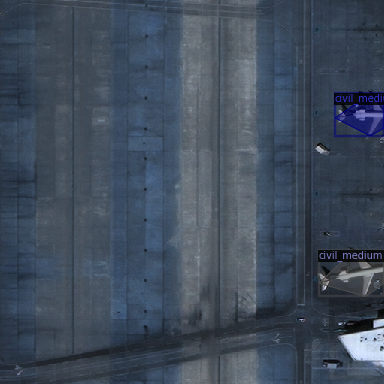

In [ ]:
# Display a random training image with annotations
d = random.sample(test_dicts, 1)
d = d[0]
print(d['file_name'])
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=satrgb_metadata, scale=0.75)
vis = visualizer.draw_dataset_dict(d)
print("filename = " + d['file_name'])
test_image = vis.get_image()[:, :, ::-1]
test_arr = np.zeros(test_image.shape,np.uint8)
test_arr[:,:,:] = test_image[:,:,:]
test_img = Image.fromarray(test_arr)
test_img.save('dj_test.png')
IImage(filename='dj_test.png') 

# Train

In [ ]:
# Train the network
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN = ("satrgb_train",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (
    300
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 class (airplane)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [ ]:
# Move tfevents file to logdir directory for TensorBoard
if not os.path.exists('logdir/'): os.makedirs('logdir/')
dirName = str(datetime.datetime.now())
os.makedirs('logdir/' + dirName)
keyword = 'tfevents'
for fname in os.listdir('output'):
    if keyword in fname:
        shutil.move('output/' + fname, 'logdir/' + dirName)

In [ ]:
# Reinstall tensorboard
!pip3 uninstall tensorboard --yes
!pip3 install tensorboard

In [ ]:
# Launch TensorBoard
%reload_ext tensorboard
%tensorboard --logdir logdir --host localhost --port=6006
url = 'http://localhost:6006/' 
IFrame(url, width=950, height=600)

# Exam the model

In [ ]:
import torch

# role model
role_model_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/models/model_0023999.pth"
role_model_pth = torch.load(role_model_dir)
print(role_model_pth['model']["roi_heads.box_predictor.cls_score.weight"].shape)
print(role_model_pth['model']["roi_heads.box_predictor.bbox_pred.weight"].shape)

# aircraft model
af_model_dir = "/content/drive/My Drive/111 Rendered.ai/rareplane_models/model_0043999.pth"
af_model_pth = torch.load(af_model_dir)
print(af_model_pth['model']["roi_heads.box_predictor.cls_score.weight"].shape)
print(af_model_pth['model']["roi_heads.box_predictor.bbox_pred.weight"].shape)

torch.Size([4, 1024])
torch.Size([12, 1024])
torch.Size([2, 1024])
torch.Size([4, 1024])


So the model checkpoints weights mismatched the given data. So we could only stick to the aircraft model.

Question: Is it possible that the model is trained using only the civil planes?

# Inferences

Here you could load either fast-RCNN or mask-RCNN to do inference.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
# cfg.MODEL.WEIGHTS = "/content/drive/My Drive/111 Rendered.ai/rareplane_models/model_0043999.pth" # aircraft_model
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/models/model_0023999.pth" # role model


In [ ]:
cfg.DATASETS.TEST = ("dj_instance_test5", )

In [ ]:
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 1 class for aircraft(airplane), 7 for role
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.modeling import build_model
model = build_model(cfg)

filename = /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/real/civil_test/126_104001000C4AEE00_tile_1544.png


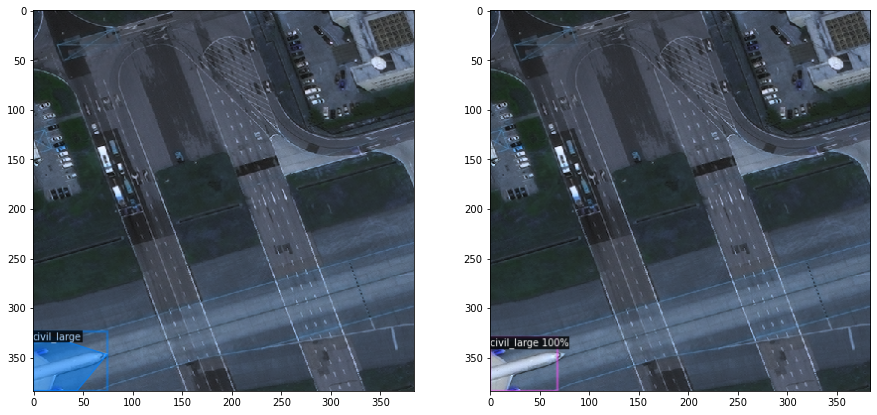

In [ ]:
# Make a sample inference

# Obtain a sample test image
d = random.sample(test_dicts, 1)
d = d[0]

# Ground truth image
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=satrgb_metadata, scale=0.75)
vis = visualizer.draw_dataset_dict(d)
test_image = vis.get_image()[:, :, ::-1]
test_arr = np.zeros(test_image.shape,np.uint8)
test_arr[:,:,:] = test_image[:,:,:]
test_img = Image.fromarray(test_arr)
test_img.save('test.png')

# Inference image
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], metadata=satrgb_metadata, scale=0.75, instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
inf_image = v.get_image()[:, :, ::-1]
inf_arr = np.zeros(inf_image.shape,np.uint8)
inf_arr[:,:,:] = inf_image[:,:,:]
inf_img = Image.fromarray(inf_arr)
inf_img.save('inf.png')

print("filename = " + d['file_name'])

%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 15,10
# read images
img_A = mpimg.imread('test.png')
img_B = mpimg.imread('inf.png')
# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);


### wrong predictions summary? We need an evaluation criteria...

what types of wrong predictions could we have?

1. right bbox, wrong pred
2. wrong bbox, wrong pred
3. wrong bbox, right pred
4. no bbox... How to know if this is the case?

### Intuition of the bbox

- bbox = annotation['bbox']

think about the x-y plane of the image.
- bbox[0] = 0 # x left
- bbox[1] = 215 # y up
- bbox[2] = 160 # delta x
- bbox[3] = 150 # delta y

! check buffer bbox 

# Test Metrics

In [ ]:
# cd /content/drive/MyDrive/111 Rendered.ai/RarePlanes/output/synthetic_test_aircraft

In [ ]:
cd /content/drive/MyDrive/111 Rendered.ai/RarePlanes/output/real_test_role_civil

/content/drive/MyDrive/111 Rendered.ai/RarePlanes/output/real_test_role_civil


In [ ]:
# Generate test metrics
coco_instance_name = "dj_instance_test5"
evaluator = COCOEvaluator(coco_instance_name, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, coco_instance_name)

WARNING [11/22 06:14:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/22 06:14:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/22 06:14:25 d2.data.datasets.coco]: Loaded 2601 images in COCO format from /content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/coco_data/civil_role_real_test_coco.json
[11/22 06:14:25 d2.data.build]: Distribution of instances among all 3 categories:
|  category   | #instances   |   category   | #instances   |  category   | #instances   |
|:-----------:|:-------------|:------------:|:-------------|:-----------:|:-------------|
| civil_small | 2616         | civil_medium | 2874         | civil_large | 967          |
|             |              |              |              |             |              |
|    total    | 6457         |              |              |           

In [ ]:
# Print test metric summary to file
if not os.path.exists('metricsdir/'): os.makedirs('metricsdir/')
test_metrics_file = './metricsdir/test-metrics-satrgb-rareplanes-od-' + str(datetime.datetime.now()) + '.txt' # current date and time

f = open(test_metrics_file, "x")
f.write(str(inference_on_dataset(model, val_loader, evaluator)))
f.close()
# another equivalent way to evaluate the model is to use `trainer.test`

[11/22 06:14:32 d2.evaluation.evaluator]: Start inference on 2601 images
[11/22 06:14:34 d2.evaluation.evaluator]: Inference done 11/2601. 0.0452 s / img. ETA=0:04:12
[11/22 06:14:39 d2.evaluation.evaluator]: Inference done 44/2601. 0.0455 s / img. ETA=0:06:13
[11/22 06:14:44 d2.evaluation.evaluator]: Inference done 73/2601. 0.0456 s / img. ETA=0:06:38
[11/22 06:14:50 d2.evaluation.evaluator]: Inference done 104/2601. 0.0457 s / img. ETA=0:06:46
[11/22 06:14:55 d2.evaluation.evaluator]: Inference done 136/2601. 0.0456 s / img. ETA=0:06:44
[11/22 06:15:01 d2.evaluation.evaluator]: Inference done 172/2601. 0.0456 s / img. ETA=0:06:33
[11/22 06:15:06 d2.evaluation.evaluator]: Inference done 204/2601. 0.0457 s / img. ETA=0:06:26
[11/22 06:15:11 d2.evaluation.evaluator]: Inference done 241/2601. 0.0457 s / img. ETA=0:06:11
[11/22 06:15:16 d2.evaluation.evaluator]: Inference done 266/2601. 0.0456 s / img. ETA=0:06:17
[11/22 06:15:21 d2.evaluation.evaluator]: Inference done 297/2601. 0.0456 s

Now let's try to study the output fiels:

In [ ]:
cd /content/drive/MyDrive/111 Rendered.ai/RarePlanes/output/real_test_role_civil

/content/drive/MyDrive/111 Rendered.ai/RarePlanes/output/real_test_role_civil


In [ ]:
ls output/

coco_instances_results.json  instances_predictions.pth


In [ ]:
import json
import pandas as pd


res_coco_dir = "./output/coco_instances_results.json"
with open(res_coco_dir) as json_file:
    res = json.load(json_file)

res = pd.DataFrame(res)
print("Num predicted bbox/instances:{}".format(res.shape[0]))
print("Score min:{}, max:{}".format(res.score.min(), res.score.max()))
res.describe()

Num predicted bbox/instances:113128
Score min:0.5013246536254883, max:1.0


,image_id,category_id,score
count,113128.000000,113128.000000,113128.000000
mean,1349.940094,0.071220,0.999288
std,783.902359,0.363591,0.013899
min,1.000000,0.000000,0.501325
25%,673.000000,0.000000,1.000000
50%,1347.000000,0.000000,1.000000
75%,2026.000000,0.000000,1.000000
max,2710.000000,2.000000,1.000000


instances_predictions.pth are the predictions made by the model on the validation set.

In [ ]:
instance_pred_dir = "./output/instances_predictions.pth"
# instance_pred_dir = "/content/sample_data/output/instances_predictions.pth"

instance_pred = torch.load(instance_pred_dir)
print(len(instance_pred))
print(instance_pred[0].keys())
print(instance_pred[0]["image_id"])
print(len(instance_pred[0]["instances"]))

preds = []
for k in range(len(instance_pred)):
    n_instances=len(instance_pred[k]["instances"])
    for i in range(n_instances):
        preds.append(instance_pred[k]["instances"][i])
print(len(preds))

2601
dict_keys(['image_id', 'instances'])
1
35
113128


In [ ]:
pred_df = pd.DataFrame(preds)
pred_df.head()

,image_id,category_id,bbox,score
0,1,0,"[353.2025451660156, 0.0, 0.00091552734375, 512.0]",1.0
1,1,0,"[16.686931610107422, 0.0, 5.802152633666992, 5...",1.0
2,1,0,"[63.46063232421875, 0.0, 0.001445770263671875,...",1.0
3,1,0,"[129.18148803710938, 0.0, 7.97308349609375, 51...",1.0
4,1,0,"[40.41171646118164, 0.0, 0.00109100341796875, ...",1.0
